## This notebook describes my imputation procedure for filling in missing values in my edge properties.

In [56]:
# Imports and miscellany

import csv
import itertools
import pickle
import string
import graphHandler as gh
import inventoryCleaner as iC
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline

# Helper functions

def representsInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

def buildRange(x):
    result = []
    if pd.isnull(x)==True:
        return np.nan
    for part in x.split(','):
        if '-' in part:
            a, b = part.split('-')
            if (representsInt(a)==False):
                strarr = []
                for i in range(ord(a), ord(b)+1):
                    strarr.append(chr(i))
                result.extend(strarr)
            else:
                a, b = int(a), int(b)
                result.extend(range(a, b + 1))
        else:
            if (representsInt(part)==False):
                result.append(part)
            else:
                a = int(part)
                result.append(a)
    return result

def existin(x):
    r = reqs[reqs['Variable']==x]['Reasonable range'].tolist()
    return r

In [41]:
# The first step is to bring in a CSV full of properties and requirements for my data set. 

pathtoreqs = '/home/louisf/Documents/Insight/massdriver/docs/road_inventory_params.csv'
reqs = pd.read_csv(pathtoreqs, delimiter = '^')

In [42]:
# Do a little bit of cleaning to convert some stuff and drop some rows
reqs['Reasonable range'] = reqs['Reasonable range'].map(buildRange)
reqs = reqs[reqs['Disqualify']==False]

In [43]:
# Load in my database 
fpath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RoadInventory.geojson'
pdinv = iC.PDInventory('roadInventory', 'test')
pdinv.geojsontodf(fpath)

toy = pdinv.table
for colname in toy.columns:
    if (sum(colname==reqs['Variable'])!=1):
        toy.drop(colname, inplace=True, axis=1)
        


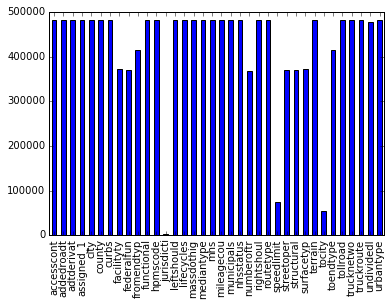

In [44]:
# Check on how many of the remaining features exceed some threshold of in-range values.

df = pd.DataFrame(index=toy.columns,columns=['value', 'hasbounds'])

for colname in toy.columns:
    nrange = existin(colname)[0]
    if type(nrange)!=float:
        df.loc[colname]= sum(toy[colname].isin(nrange))
        
for row in df.index:
    r = existin(row)[0]
    if type(r) == float:
        df.loc[row]['hasbounds'] = False
    else:
        df.loc[row]['hasbounds'] = True

# Examine only entries with bounds for removal:

df.loc[df['hasbounds']==True]
df.loc[df['hasbounds']==True].value.plot(kind='bar')

# Drop all entries with fewer than 10% of values within bounds
df = df[df['value']<50000]

# The indices of df correspond to all of the properties we will drop from our table.

# Based on this inspection, we will drop:
# fromcity
# fromstate
# iristatus
# jurisdicti
# opposingdi
# oppositenu
# tostate

# This removal occurs in road_inventory_params.

In [47]:
# Next, I will load in my graph. I will use the pickle I generated previously.
picklepath = '/home/louisf/Documents/Insight/massdriver/notebooks/graph_with_risk2.pickle'
graph = nx.read_gpickle(picklepath)

In [78]:
newNet = graph.net

In [61]:
# Just kidding! I need to generate a new graph with all of the properties I am interested in.

graph = gh.NetworkGenerator()
filepath = '/home/louisf/Documents/Insight/massdriver/data/raw/shapefile/RI_converted.shp'
graph.loadGraph(filepath=filepath, fields=toy.columns.tolist(), simplify=True)
newNet = graph.net

good = 481430, bad = 30


In [151]:
# Iterate over each edge. Find the properties on that edge that are missing. 
importantProperties = toy.columns.tolist()
nrange = reqs['Reasonable range']
for u,v in graph.net.edges_iter():
    g = newNet[u][v]
    missingProps = []
    for props in importantProperties:
        nrange = reqs.loc[reqs['Variable']==props]['Reasonable range']
        if type(nrange.tolist()[0])!=float:
            print(props + ' is in range {}'.format(g[props] in nrange.tolist()[0]))
            if ((g[props] in nrange.tolist()[0])==False):
                missingProps.append(props)
        else:
            print(props + ' has no range specified')
    break


accesscont is in range True
addedroadt is in range True
adt has no range specified
adtderivat is in range True
adtyear has no range specified
assigned_1 is in range True
assignedle has no range specified
city is in range True
county is in range False
curbs is in range True
equation_1 has no range specified
equationro has no range specified
facilityty is in range True
federalaid has no range specified
federalfun is in range True
fromendtyp is in range True
frommeasur has no range specified
fromstreet has no range specified
functional is in range True
hpmscode is in range True
jurisdicti is in range False
leftshou_1 has no range specified
leftshould is in range True
leftsidewa has no range specified
lifecycles is in range True
massdothig is in range True
mediantype is in range True
medianwidt has no range specified
mhs is in range True
mileagecou is in range True
mpo has no range specified
municipals is in range True
nhsstatus is in range True
numberofpe has no range specified
numberoftr

In [154]:
missingProps

['county', 'jurisdicti', 'tocity']

In [148]:
import itertools
list(itertools.chain(*neighbors))

[(-71.10750084168293, 42.47446692343721),
 (-71.10634505726127, 42.47441237903289),
 (-71.10891187098966, 42.474431813774984)]

In [155]:
nx.write_gpickle(graph.net, '/home/louisf/Documents/Insight/massdriver/data/largeGraph.npickle')

In [ ]:
# For each node on the edge, find the properties of the edges attached to that node.

In [ ]:
# Find all properties that are with an acceptable range within that set, and use those to impute missing value.